In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score

def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from glob import glob

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('D:\\Data\\AI604_project\\NIH\\Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                        glob(os.path.join('D:\\Data\\AI604_project\\NIH', 'images*', '*', '*.png'))}

anno_path = pd.read_csv('D:\\Data\\AI604_project\\NIH\\BBox_List_2017.csv')
anno_df = anno_path.loc[:,['Image Index','Finding Label','Bbox [x','y','w','h]']]   # drop uncecessary columns
anno_df['Image Index'] = anno_df['Image Index'].map(data_image_paths.get)
anno_df.rename(columns={'Bbox [x':'x',"h]":'h'}, inplace=True)


In [3]:
# label -> number
anno_df['Finding Label'] = anno_df['Finding Label'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*anno_df['Finding Label'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
# print(anno_df)
for c_label in all_labels:
    anno_df[c_label] = anno_df['Finding Label'].map(lambda finding: 1.0 if c_label in finding else 0)
anno_df['disease_vec'] = anno_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

All Labels (8): ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


In [4]:
class_col = []
for index, row in anno_df.iterrows() :
    #print(row['disease_vec'])
    index_disease = np.where(row['disease_vec'] == 1.0)
    #print(index_disease[0])
    class_col.append(index_disease[0][0])
anno_df['Finding Label'] = class_col
anno_df = anno_df.drop(anno_df.columns[6:], axis=1)
anno_df


,Image Index,Finding Label,x,y,w,h
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778


In [5]:
def center_to_corner(center_boxes):
    """
    input
    center_boxes : center coordinates boxes : [N, 4] (cx, cy, w, h)
    output
    corner_boxes : corner coordinates boxes : [N, 4] (x1, y1, x2, y2)
    """
    center_boxes['xmin'] = center_boxes.loc[:,'x'] - (center_boxes.loc[:,'w'])/2
    center_boxes['ymin'] = center_boxes.loc[:,'y'] - (center_boxes.loc[:,'h'])/2
    center_boxes['xmax'] = center_boxes.loc[:,'x'] + (center_boxes.loc[:,'w'])/2
    center_boxes['ymax'] = center_boxes.loc[:,'y'] + (center_boxes.loc[:,'h'])/2

    return center_boxes

In [6]:
df_train = center_to_corner(anno_df)

In [7]:
df_train.loc[df_train['xmin'] < 0, 'xmin'] = 0
df_train.loc[df_train['ymin'] < 0, 'ymin'] = 0
df_train.loc[df_train['xmax'] < 0, 'xmax'] = 0
df_train.loc[df_train['ymax'] < 0, 'ymax'] = 0
df_train

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441,181.694915,507.425996,268.474576,586.612437
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525,593.355932,0.000000,778.847458,288.289261
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153,144.271186,208.578539,299.389831,425.527691
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034,655.728814,467.290403,796.745763,522.612437
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695,559.728814,530.729939,760.406780,608.831634
...,...,...,...,...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889,0.000000,191.336302,506.709340,514.465191
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556,650.069340,540.634080,753.607118,604.349635
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556,4.949340,611.745191,276.878229,706.180747
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778,52.736007,528.687413,297.358229,632.225191


In [8]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    #print("x shape : ", x.shape)
    Y = np.zeros((rows, cols))
    #print("Y shape", Y.shape)
    bb = bb.astype(np.int)
    #print(bb[0],bb[2], bb[1], bb[3])
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    #print(Y[bb[0]:bb[2], bb[1]:bb[3]])
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    #print(cols, rows)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[7],x[6],x[9],x[8]])

In [10]:
#Populating Training DF with new paths and bounding boxes
new_bbs = []
for index, row in df_train.iterrows():
    # print(row['Image Index'])
    im = read_image(row['Image Index'])
    bb = create_bb_array(row.values)
    
    Y = create_mask(bb, im)
    new_bb = mask_to_bb(Y)
    new_bbs.append(new_bb)
df_train['new_bb'] = new_bbs

## Sample Image


In [171]:
sample_idx = df_train['Image Index'].str.contains("00000344_003")
sample_idx2 = df_train['Image Index'].str.contains("00000808_002")
sample_idx3 = df_train['Image Index'].str.contains("00002533_002")
sample_idx4 = df_train['Image Index'].str.contains("00005532_022")
sample_idx5 = df_train['Image Index'].str.contains("00017188_002")
sample_idx6 = df_train['Image Index'].str.contains("00029259_027")
sample_df1 = df_train[sample_idx]
sample_df2 = df_train[sample_idx2]
sample_df3 = df_train[sample_idx3]
sample_df4 = df_train[sample_idx4]
sample_df5 = df_train[sample_idx5]
sample_df6 = df_train[sample_idx6]
sample_df = pd.concat([sample_df1, sample_df2, sample_df3, sample_df4, sample_df5, sample_df6])
sample_df

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax,new_bb
320,D:\Data\AI604_project\NIH\images_001\images\00...,2,172.373333,230.153490,97.848889,221.866667,123.448889,119.220156,221.297778,341.086823,"[119.0, 123.0, 340.0, 220.0]"
12,D:\Data\AI604_project\NIH\images_001\images\00...,0,558.101695,384.307352,227.796610,167.050847,444.203390,300.781929,672.000000,467.832776,"[300.0, 444.0, 466.0, 671.0]"
383,D:\Data\AI604_project\NIH\images_002\images\00...,2,280.651852,26.006349,209.134392,534.213757,176.084656,0.000000,385.219048,293.113228,"[0.0, 176.0, 292.0, 384.0]"
779,D:\Data\AI604_project\NIH\images_003\images\00...,6,548.977778,201.709045,174.080000,190.008889,461.937778,106.704601,636.017778,296.713490,"[106.0, 461.0, 295.0, 635.0]"
341,D:\Data\AI604_project\NIH\images_008\images\00...,2,199.680000,480.464601,228.693333,91.022222,85.333333,434.953490,314.026667,525.975712,"[434.0, 85.0, 524.0, 313.0]"
927,D:\Data\AI604_project\NIH\images_012\images\00...,7,787.775661,386.844444,112.694180,291.487831,731.428571,241.100529,844.122751,532.588360,"[241.0, 731.0, 531.0, 843.0]"


In [184]:
sample_df.values[5][0]

'D:\\Data\\AI604_project\\NIH\\images_012\\images\\00029259_027.png'

In [140]:
im = cv2.imread(str(sample_df.values[0][0]))
bb = create_bb_array(df_train.values[0])
print(im.shape)

(1024, 1024, 3)


In [141]:
np.max(im)

255

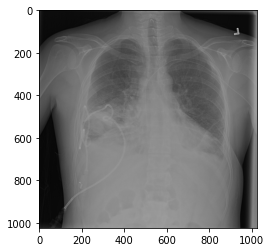

In [142]:
plt.imshow(im)

### Bounding Box

In [143]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([507., 181., 585., 267.], dtype=float32)

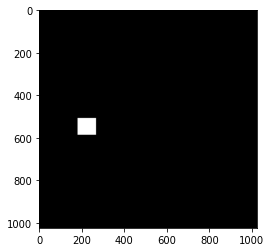

In [144]:
plt.imshow(Y, cmap='gray')

## GradCAM

In [169]:
cam1 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00000344_003.npy")
cam2 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00000808_002.npy")
cam3 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00002533_002.npy")
cam4 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00005532_022.npy")
cam5 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00017188_002.npy")
cam6 = np.load("D:\\Data\\AI604_project\\gradCAM2\\NIH_test\\00029259_027.npy")
cam = np.stack((cam1, cam2, cam3, cam4, cam5, cam6), axis=0)
cam.shape

(6, 1024, 1024)

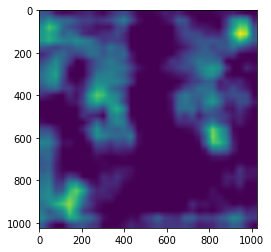

In [164]:
plt.imshow(cam1)

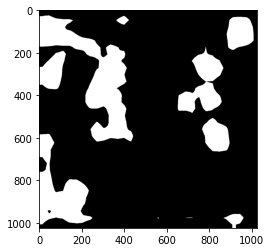

In [165]:
cam1 = np.where(cam1>0.3, 1.0, 0.0)
plt.imshow(cam1, cmap='gray')

## IoU

In [151]:
print(Y.shape, cam1.shape)
print(type(Y), type(cam3))

(1024, 1024) (1024, 1024)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [166]:
SMOOTH = 1e-6

def iou_numpy(outputs: np.array, labels: np.array):
    # outputs = outputs.squeeze(1)

    outputs = outputs.astype(int)
    labels = labels.astype(int)
    
    intersection = (outputs & labels).sum((0,1))
    print("intersection : ", intersection)
    union = (outputs | labels).sum((0,1))
    print("union : ", union)
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    # print("before np.ceil ", iou)
    # thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return iou.mean()  # Or thresholded.mean()

def iou_numpy2(outputs: np.array, labels: np.array):
    
    intersection = (outputs * labels).sum((0,1))
    print("intersection : ", intersection)
    union = outputs.sum((0,1)) + labels.sum((0,1))
    print("union : ", union)
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    return iou.mean()  # Or thresholded.mean()

def dice_numpy(outputs: np.array, labels: np.array):
   
    intersection = (outputs * labels).sum((0,1))
    #print("intersection : ", intersection)
    union = outputs.sum((0,1)) + labels.sum((0,1))
    #print("union : ", union)
    
    dice = 2.0 * (intersection + SMOOTH) / (union + SMOOTH)
    
    return dice.mean()  # Or thresholded.mean()

In [155]:
threshold = iou_numpy2(Y, cam1)
threshold

intersection :  1052.0
union :  226096.0


0.004652890811846946

In [156]:
dice = dice_numpy(Y, cam1)
dice

intersection :  1052.0
union :  226096.0


0.009305781623693892

## Test 6 images

=========== Sample  0
[507.42599642 181.69491525 586.6124371  268.47457627]


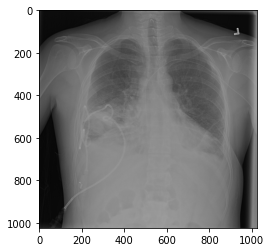

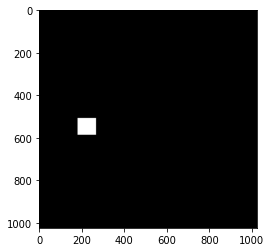

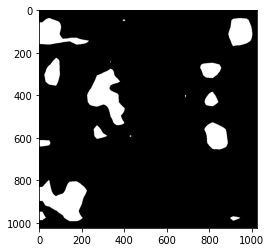

intersection :  341
union :  112024
IOU :  0.003043990582348033
Dice :  0.006069505646722115
=========== Sample  1
[  0.         593.3559322  288.28926112 778.84745763]


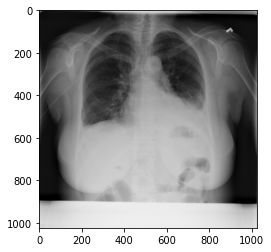

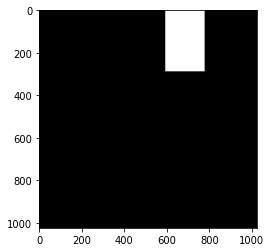

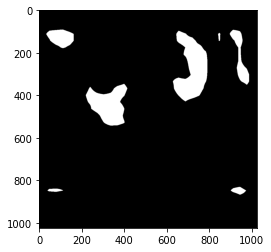

intersection :  14710
union :  111624
IOU :  0.13178169570046064
Dice :  0.232874760569341
=========== Sample  2
[208.5785388  144.27118644 425.52769134 299.38983051]


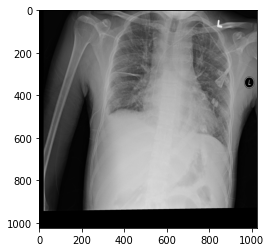

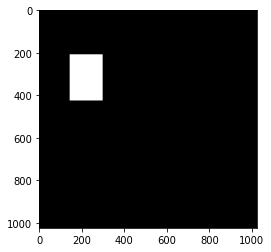

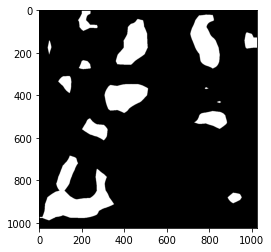

intersection :  2131
union :  167102
IOU :  0.012752689979696516
Dice :  0.025184213492491506
=========== Sample  3
[467.2904032  655.72881356 522.6124371  796.74576271]


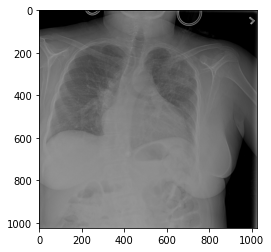

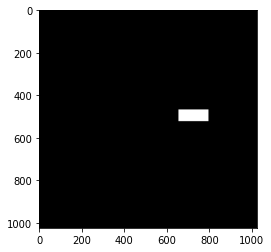

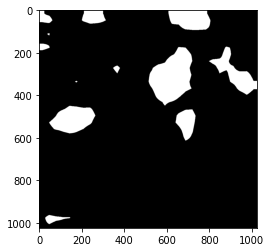

intersection :  3826
union :  113775
IOU :  0.03362777412407271
Dice :  0.0650674739324915
=========== Sample  4
[530.72993909 559.72881356 608.831634   760.40677966]


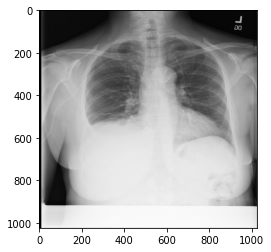

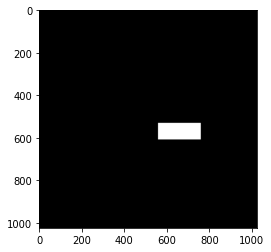

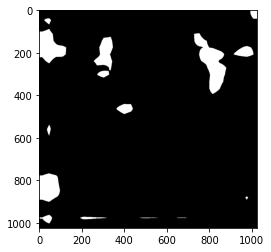

intersection :  0
union :  77687
IOU :  1.2872166514180338e-11
Dice :  2.5744333028360676e-11
=========== Sample  5
[415.74688824 567.86440678 595.81468485 624.27118644]


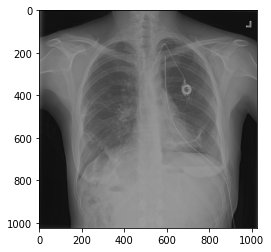

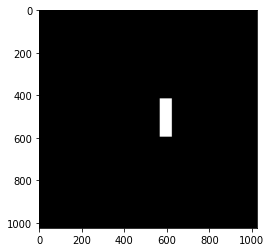

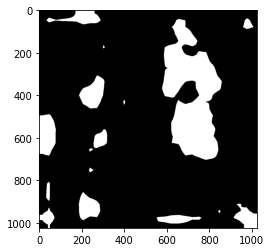

intersection :  142
union :  179919
IOU :  0.0007892440542644787
Dice :  0.0015772432786579145


In [185]:
THRESHOLD = 0.4

for row in range(len(sample_df)) :
    print("=========== Sample ",row)
    im = cv2.imread(str(sample_df.values[row][0]))
    bb = create_bb_array(df_train.values[row])
    print(bb)
    Y = create_mask(bb, im)
    mask_to_bb(Y)
    plt.imshow(im)
    plt.show()
    plt.imshow(Y, cmap='gray')
    plt.show()
    
    cam_sample = cam[row]
    cam_sample = np.where(cam_sample>THRESHOLD, 1.0, 0.0)
    plt.imshow(cam_sample, cmap='gray')
    plt.show()

    iou = iou_numpy(Y, cam_sample)
    print("IOU : " ,iou)
    dice = dice_numpy(Y, cam_sample)
    print("Dice : ", dice)
    